# Q2：Are there some redundant bus routes that can be cancelled?
Answer: No, we don’t think there are any redundant bus routes existed in the Kingston right now. 

We analyze the given transit record data of Kingston in 2017 October, the dataset contains features including date/time, operation, user class, bus route number and coordinates bus stop of the record. To find a redundant route, we consider that the bus route which has the least number of user records is a redundant bus route. Since the least number of user records represent that either the bus route is designed to locate away from the neighborhoods or there exists another route that has more departures in the same length of running period. 


In [ ]:
import requests
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import descartes
import geopandas as gpd
from shapely.geometry import Point,Polygon
%matplotlib inline

stop_api_url = "https://opendatakingston.cityofkingston.ca/api/records/1.0/search/?dataset=transit-gtfs-stops&q=&rows=799"
driveway_api_url = "https://opendatakingston.cityofkingston.ca/api/records/1.0/search/?dataset=driveways&q=&rows=-1&facet=material"
busroute_api_url = 'https://opendatakingston.cityofkingston.ca/api/records/1.0/search/?dataset=transit-gtfs-routes&q=&rows=-1&facet=route_short_name&exclude.route_long_name=999+Maintenance+-+Out+of+Service'
stop_response = requests.get(stop_api_url)
driveway_response = requests.get(driveway_api_url)
busroute_response = requests.get(busroute_api_url)

In [ ]:
driveway_response.status_code

200

In [ ]:
x = stop_response.json()
x_driveway = driveway_response.json()
x_busroute = busroute_response.json()

In [ ]:
transit_stops = pd.json_normalize(x,'records')
driveways = pd.json_normalize(x_driveway,'records')
busroute = pd.json_normalize(x_busroute,'records')

In [ ]:
transit_stops = pd.json_normalize(x,'records')
driveways = pd.json_normalize(x_driveway,'records')
busroute = pd.json_normalize(x_busroute,'records')

In [ ]:
latitude=[]
longitude=[]
for i in busroute['fields.shape.coordinates'][0][0]:
  latitude.append(i[1])
  longitude.append(i[0])

In [ ]:
matrixA={}
matrixA['latitude']=latitude 
matrixA['longitude']=longitude

matrixA=pd.DataFrame(matrixA)

In [ ]:
#This is the part where need the user to upload the Transit Data - October.xlsx file into local path.
from google.colab import files
uploaded = files.upload()

Saving Transit Data - October.xlsx to Transit Data - October.xlsx


In [ ]:
df = pd.read_excel('/content/Transit Data - October.xlsx')

In [ ]:
df.describe()

,Bus,Route,Latitude,Longitude
count,704539.000000,704539.000000,704539.000000,704539.000000
mean,1241.137280,239.365809,40.941516,-70.604451
std,317.249714,288.489481,13.694826,21.473093
min,315.000000,1.000000,0.000000,-255.426092
25%,1047.000000,3.000000,44.224635,-76.526580
50%,1361.000000,15.000000,44.232833,-76.502100
75%,1480.000000,502.000000,44.248020,-76.486999
max,1689.000000,701.000000,255.426092,0.000000


In the data cleaning process, we did not find any missing data within the dataset. So, we directly go to the feature generation part. There are more than 700 thousand records and the count of records related to each bus route would answer the question2. However, there is no such attribute so that we must generate it on our own. Through few lines of code, we managed to get a data frame contains the routes in the dataset and its number of records. To show the redundant routes clearly, we used the heatmap to rank the routes from the highest number of records to the lowest as the color changes from yellow to dark purple. The result heat map figure tells us that the most possible redundant bus routes are likely to be one or more bus routes within route 17, route 8, route 13 and route 14. Since it’s the dataset from Kingston, many things have been changed during these years. There is no routes 17, 8 and 13 which somehow supports our idea that the least number of use records decide which route is redundant.

In [ ]:
#Check if there is any missing values within the dataset.
df.isna().sum().sum()

0

In [ ]:
counts = dict()
for i in df['Route']:
  counts[i] = counts.get(i, 0) + 1
  

In [ ]:
count_df=pd.DataFrame.from_dict(counts, orient='index')
count_df

,0
17,1710
7,24508
701,96384
15,24001
501,78520
502,71229
1,71450
601,38617
4,31207
3,40953


In [ ]:
# creating heat map
count_df.style.background_gradient(cmap ='viridis')\
        .set_properties(**{'font-size': '20px'})

,0
17,1710
7,24508
701,96384
15,24001
501,78520
502,71229
1,71450
601,38617
4,31207
3,40953


In [ ]:
#This is the part where need the user to upload the map data inside the competition1 file.
from google.colab import files
uploaded = files.upload()

Saving civic-addresses.geojson to civic-addresses.geojson
Saving driveways.geojson to driveways.geojson
Saving landuse.cpg to landuse.cpg
Saving landuse.dbf to landuse.dbf
Saving landuse.prj to landuse.prj
Saving landuse.shp to landuse.shp
Saving landuse.shx to landuse.shx
Saving point-of-interest.geojson to point-of-interest.geojson
Saving transit-gtfs-routes.geojson to transit-gtfs-routes.geojson
Saving transit-gtfs-stops.geojson to transit-gtfs-stops.geojson


In [ ]:
# We only use four files to draw the map in colab.
streetmap=gpd.read_file('landuse.shp')
bus_routes=gpd.read_file('transit-gtfs-routes.geojson')
addresses=gpd.read_file('civic-addresses.geojson')
stops=gpd.read_file('transit-gtfs-stops.geojson')

/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:214: RuntimeWarning: Glyph 65292 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/usr/local/lib/python3.7/dist-packages/matplotlib/backends/backend_agg.py:183: RuntimeWarning: Glyph 65292 missing from current font.
  font.set_text(s, 0, flags=flags)


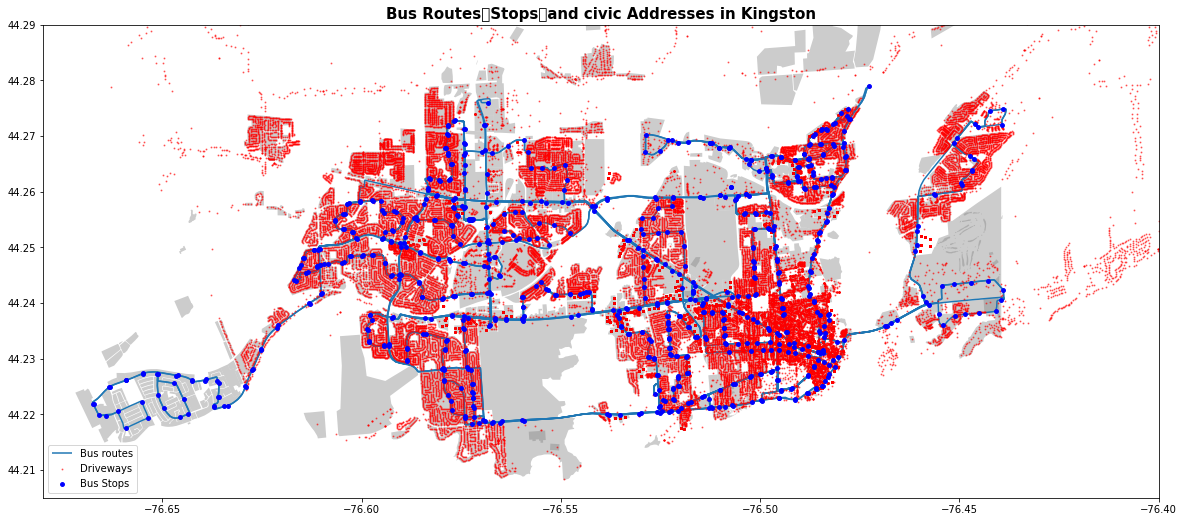

In [ ]:
fig, ax = plt.subplots(figsize=(20,20))
#Add .shp map file to axes
streetmap.plot(ax=ax, alpha=0.4, color="grey", zorder=0)
#Add bus route shapefile
bus_routes.plot(ax=ax, alpha=1, zorder=1, label='Bus routes')
# Add driveways geodataframe to axes
addresses.plot(ax=ax, alpha=0.5, markersize=1, color="red", zorder=1, label="Driveways")
# Add bus stops geodataframe to axes
stops.plot(ax=ax, alpha=1, markersize=15, color='blue', zorder=2, label='Bus Stops ' )

plt.xlim( -76.68,-76.40)
plt.ylim( 44.205,44.29)# Show map
plt.title( "Bus Routes，Stops，and civic Addresses in Kingston", fontsize=15, fontweight= "bold")
ax.legend()
plt.show()


As the graph shows, the Kingston addresses are mostly covered by the existing bus routes right now. We could tell there is no redundant bus routes. The red dots are given by the civic-addresses dataset from Kingston Dataset. They surround the route line in the Kingston city and there is only one route reaches the area that has nearly zero red dot civic address at the west-south cornor. Even that route does not have too many passengers, it’s still necessary to have a Kingston public bus system for the several citizens live in the zone.

In conclusion, there are no redundant bus routes right now in Kingston. But back to 2017, the routes such as 17, 8 and 13 might be considered as a redundant bus route due to the small number of passengers.

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=ba3a38b4-573b-4649-8117-71de8550c212' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>